In [98]:
from JupyterImport import *
from src.DatObject.Attributes import SquareEntropy as SE, Entropy as E, Transition as T, DatAttribute as DA
from src.DataStandardize.ExpSpecific.Sep20 import Fixes
root_logger.setLevel(logging.WARNING)
from GeneralFunctions import merge_dat_parts

save_graphs=True

In [88]:
# dats = get_dats((1063, 1152+1)) # Entropy scan params (varying HQPC, Frequency, Sweeprate)


# dats = get_dats((1166, 1185+1))  # Entropy vs Field (-200 -> 0mT in 50mT steps, 2 part scans each, 2 repeats at each field)

datnums = list(range(1166, 1185+1)) + list(range(1186, 1233+1)) + list(range(1234, 1239+1))  # 1st set is -200 -> 0, 2nd is -400 -> 0, 3rd is around -350mT
dats = get_dats(datnums)

for dat in dats:
    if 'LS625 Magnet Supply' in dat.Logs.full_sweeplogs.keys():
        Fixes._add_magy(dat)  # Adds temporary magy field to Other.magy
    Fixes.add_part_of(dat)
    Fixes.setpoint_averaging_fix(dat)
dat_dict = {dat.datnum: dat for dat in dats}
p1_dats = [dat for dat in dats if dat.Logs.part_of[0] == 1]
p2_dats = [dat for dat in dats if dat.Logs.part_of[0] == 2]
full_dat_pairs = list(zip(p1_dats, p2_dats))

dat_pairs = full_dat_pairs

N/A% (0 of 74) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--WARNING:src.DatObject.Attributes.Transition:LinAlgError encountered, retrying
 98% (73 of 74) |####################### | Elapsed Time: 0:00:05 ETA:   0:00:00WARNING:src.DatObject.Attributes.Transition:LinAlgError encountered, retrying
100% (74 of 74) |########################| Elapsed Time: 0:00:09 Time:  0:00:09


In [89]:
#  ONLY FOR get_dats((1063, 1152+1)) : 45 plots, array of 3 HQPCs, 5 Freqs, 3 SRs  for  
if dats[0].datnum == 1063:
    num_hqpc = 3
    num_freqs = 5
    num_srs = 3

    HQPCs = [0]
    freqs = [2,0]
    SRs = [2]

    h_dict = {0:800, 1:500, 2:300}
    f_dict = {0:45, 1:72, 2:114, 3:150, 4:198}
    s_dict = {0:500, 1:300, 2:100}

    which = None
    for i, l in enumerate([HQPCs, freqs, SRs]):
        if len(l) > 1:
            if which is not None: 
                root_logger.warning('Only one of HQPCs, freqs, SRs should have more than one entry')
            else:
                which = i

    par_x_label = ['HQPC bias /mV', 'Square Frequency /Hz', 'Sweeprate mV/s (LP*200)'][which]
    par_values = [[h_dict[h] for h in HQPCs], [f_dict[f] for f in freqs], [s_dict[s] for s in SRs]][which]

    pair_nums = [h+f*(num_srs)+s*(num_srs*num_freqs) for s in SRs for f in freqs for h in HQPCs]
    dat_pairs = [full_dat_pairs[i] for i in pair_nums]

    # dat_pairs = full_dat_pairs


In [94]:
sub_line = True
bin_data = True  # Reduces number of points before plotting by binning
num_per_row = 400  # If bin_data is True, will aim for this number of points per row

recalculate_setpoint_averaging = False
setpoint_range = [15, None]  # How many to throw out at the beginning and end (use negative for end)

allowed_amps = (0.8, 1.2)
default_amp = 1.05
allowed_dTs = (1.0, 15.1)
default_dT = 4.7

xs, trans_datas, entropy_datas, integrated_datas, ids, trans_titles, entropy_titles, integrated_titles = list(), list(), list(), list(), list(), list(), list(), list()
integrated_entropies, fit_entropies = list(), list()
for pair in progressbar(dat_pairs):
    if recalculate_setpoint_averaging:
        for dat in pair:
            dat.SquareEntropy.Processed.process_params.setpoint_start = setpoint_range[0]
            dat.SquareEntropy.Processed.process_params.setpoint_fin = setpoint_range[1]
            dat.SquareEntropy.Processed.calculate()
    
    dat = pair[0]
    if dat.Logs.fds["LCT"] > -350:
        centers = [0]*len(dat.Data.y_array)
    else:
        centers = None  # Will center based on simple i_sense fit
        
    x, averaged_data = merge_dat_parts(pair, centers=centers)
    entropy_data = SE.entropy_signal(averaged_data)
    
    # Calculate Integrated Entropy
    line = lm.models.LinearModel()
    dat_tcs, dat_amps, dat_centers = list(), list(), list()
    for data in averaged_data[0::2]:
        fit = T.transition_fits(x, data, func=T.i_sense)[0]
        dat_tcs.append(fit.best_values['theta'])
        dat_amps.append(fit.best_values['amp'])
        dat_centers.append(fit.best_values['mid'])
    dat_ths = list()
    for data in averaged_data[1::2]:
        fit = T.transition_fits(x, data, func=T.i_sense)[0]
        dat_ths.append(fit.best_values['theta'])
    tc = np.nanmean(dat_tcs)
    th = np.nanmean(dat_ths)
    dT = th-tc
    amp = np.average(dat_amps)
    mid = np.average(dat_centers)
    mid = mid if (-1000 < mid < 1000) else 0
    
    if not (allowed_amps[0] < amp < allowed_amps[1]):
        amp = default_amp
    if not (allowed_dTs[0] < dT < allowed_dTs[1]):
        dT = default_dT
        
    dat.Other.tc = tc
    dat.Other.th = th
    dat.Other.dT = dT
    dat.Other.amp = amp
    dat.Other.mid = mid
    
    dx = np.mean(np.diff(x))
    sf = SE.scaling(dt=dT, amplitude=amp, dx=dx)
    int_info = SE.IntegratedInfo(dT=dT, amp=amp, dx=dx)
    integrated_data = SE.integrate_entropy(entropy_data, int_info.sf)
    
    dat.Other.sf = sf
    
    if sub_line is True:
        indexs = CU.get_data_index(x, [mid-4000, mid-1000])
        line_fit = line.fit(integrated_data[indexs[0]:indexs[1]], x=x[indexs[0]:indexs[1]], nan_policy='omit')
        integrated_data = integrated_data-line_fit.eval(x=x)
        
    indexs = CU.get_data_index(x, [mid+600, mid+1000])
    int_dS = np.mean(integrated_data[indexs[0]:indexs[1]])

    # Calculate Nik Fit
    e_pars = E.get_param_estimates(x, entropy_data)[0]
    e_pars = CU.edit_params(e_pars, 'const', 0, False)
    efit = E.entropy_fits(x, entropy_data, params=e_pars)[0]
    efit_info = DA.FitInfo()
    efit_info.init_from_fit(efit)
    
    dat.Other.efit_info = efit_info
    
    if bin_data is True:
        bin_size = np.ceil(x.shape[-1]/num_per_row)
        averaged_data = CU.bin_data(averaged_data, bin_size)
        entropy_data = CU.bin_data(entropy_data, bin_size)
        integrated_data = CU.bin_data(integrated_data, bin_size)
        x = np.linspace(x[0], x[-1], int(x.shape[-1]/bin_size))
    
    ids.append(f'{dat.datnum}')
    xs.append(x)
    trans_datas.append(averaged_data)
    entropy_datas.append([efit_info.eval_fit(x=x), entropy_data])
    integrated_datas.append(integrated_data)
    integrated_entropies.append(int_dS)
    fit_entropies.append(efit_info.best_values.dS)
    
    


N/A% (0 of 37) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--WARNING:src.DatObject.Attributes.Transition:LinAlgError encountered, retrying
  2% (1 of 37) |                         | Elapsed Time: 0:00:00 ETA:   0:00:26WARNING:src.DatObject.Attributes.Transition:LinAlgError encountered, retrying
 97% (36 of 37) |####################### | Elapsed Time: 0:00:26 ETA:   0:00:00WARNING:src.DatObject.Attributes.Transition:LinAlgError encountered, retrying
100% (37 of 37) |########################| Elapsed Time: 0:00:26 Time:  0:00:26


In [95]:
for pair in dat_pairs:
    dat = pair[0]
    channel_ratio = round(dat.AWG.AWs[1][0][1]/dat.AWG.AWs[0][0][1]/-0.028, 2)
    dsp = dat.SquareEntropy.Processed
    scan_freq = dat.Logs.Fastdac.measure_freq/dat.AWG.info.wave_len
    fit_text = f'SF={dat.Other.sf:.2f}, Amp={dat.Other.amp:.3f}nA, T_cold={dat.Other.tc:.3f}mV, T_hot={dat.Other.th:.3f}mV, dT={dat.Other.dT:.3f}mV, fit_dS={dat.Other.efit_info.best_values.dS:.3f}kB'
    scan_text = f'LCT={dat.Logs.fds["LCT"]}, HQPCbiases=({dat.AWG.AWs[0][0][1]:.0f}mV, {dat.AWG.AWs[0][0][3]:.0f}mV), Channel Biases=({dat.AWG.AWs[1][0][1]:.1f}mV, {dat.AWG.AWs[1][0][3]:.1f}mV), Perp Field={dat.Other.magy.field:.1f}mT'
    array_text = f'Channel Bias Ratio = {channel_ratio}, Square Wave Frequency = {scan_freq:.1f}Hz, Sweeprate (LP*200) = {dat.Logs.sweeprate:.1f}mV/s'
    text_info = f'{array_text}<br>{scan_text}<br>{fit_text}'
    trans_titles.append(f'Dat{dat.datnum}: Averaged CS data<br>{text_info}')
    entropy_titles.append(f'Dat{dat.datnum}: Entropy data with fit<br>{text_info}')
    integrated_titles.append(f'Dat{dat.datnum}: Integrated Entropy data<br>{text_info}')


fig1 = PlU.get_figure(datas=trans_datas, xs=xs, ids=ids, titles=trans_titles, labels=['v0_0', 'vp', 'v0_1', 'vm'], xlabel=f'{dat.Logs.x_label}', ylabel='Current /nA', plot_kwargs={'mode':'lines+markers'})
fig2 = PlU.get_figure(datas=entropy_datas, xs=xs, ids=ids, titles=entropy_titles, labels=['fit', 'data'], xlabel=f'{dat.Logs.x_label}', ylabel='Current /nA', plot_kwargs={'mode':'lines+markers'})
fig3 = PlU.get_figure(datas=integrated_datas, xs=xs, ids=ids, titles=integrated_titles, xlabel=f'{dat.Logs.x_label}', ylabel='Entropy /kB', plot_kwargs={'mode':'lines+markers'})

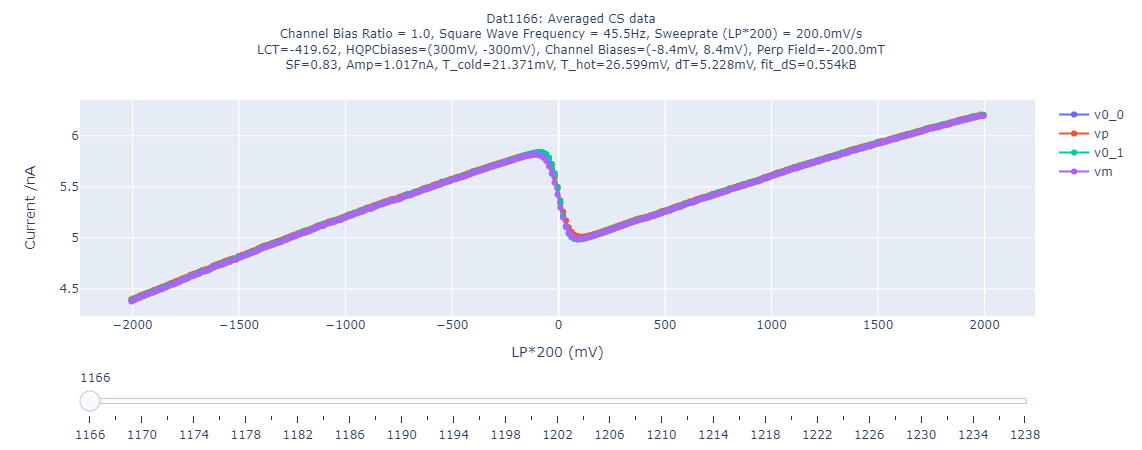

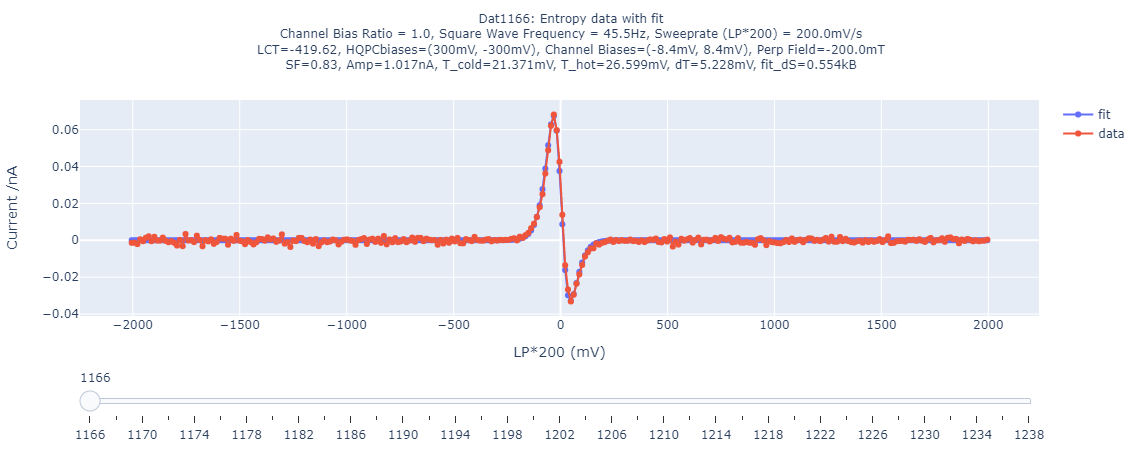

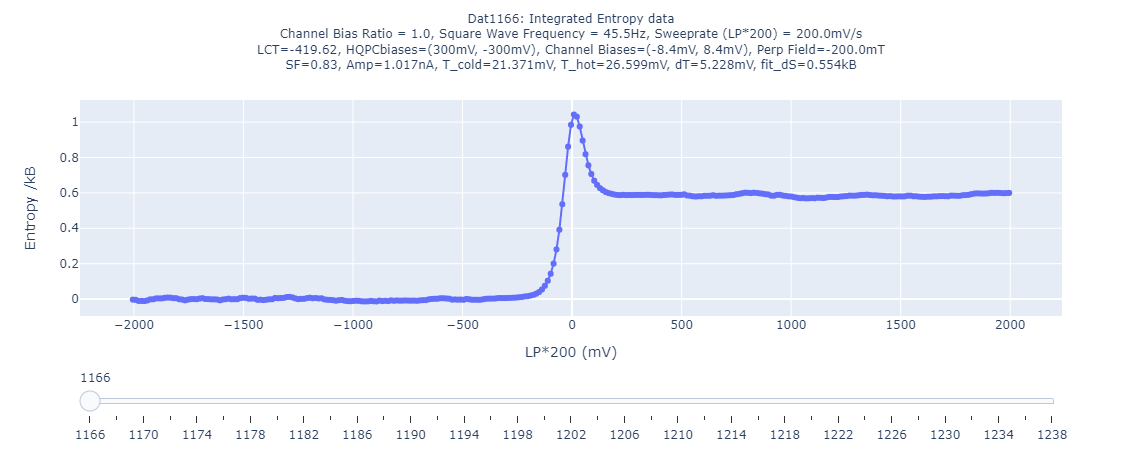

In [99]:
save_graphs= save_graphs
for fig, name in zip([fig1, fig2, fig3], ['AveragedCS_vs_Channel_bias', 'Average_Entropy_With_Fit', 'Averaged_Integrated_Entropy']):
    fig.update_layout(hovermode = 'x unified',
                     title=dict(y=0.95,x=0.5,xanchor='center',yanchor='top', font=dict(size=12)))
    if save_graphs: 
        fig.write_html(export_path+f'Dats{dats[0].datnum}-{dats[-1].datnum}{name}.html')
    fig.show()

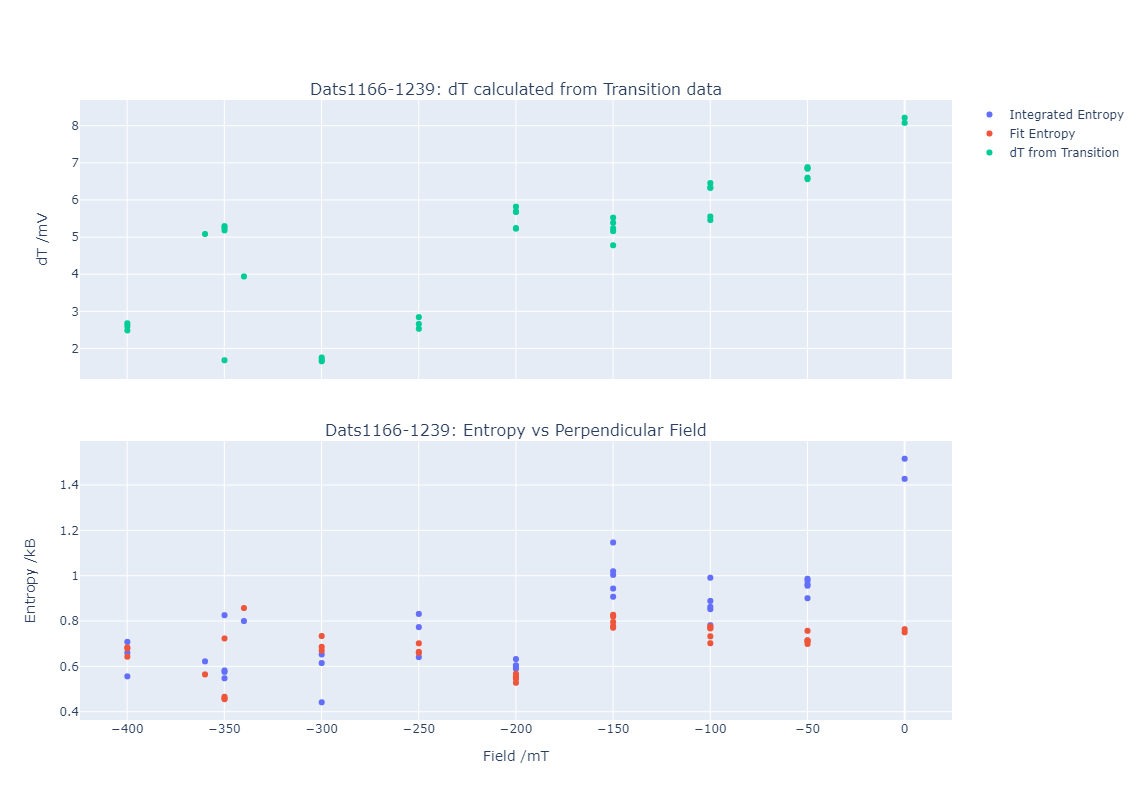

In [103]:
# FOR MAG FIELD ONLY
save_graphs = save_graphs
if dats[0].datnum == 1166:
    base_hover_template = 'Datnum:%{customdata}<br>Field:%{x:.0f}mT<br>'
    hover_template1 = base_hover_template + 'dT:%{y:.2f}mV'
    hover_template2 = base_hover_template + 'Entropy:%{y:.2f}kB'
    title1 = f'Dats{dats[0].datnum}-{dats[-1].datnum}: dT calculated from Transition data'
    title2 = f'Dats{dats[0].datnum}-{dats[-1].datnum}: Entropy vs Perpendicular Field'
    fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.1, subplot_titles=[title1, title2])

    x = [p[0].Other.magy.field for p in dat_pairs]
    datnums = [p[0].datnum for p in dat_pairs]
    dTs = [p[0].Other.dT for p in dat_pairs]

    for data, name in zip([integrated_entropies, fit_entropies], ['Integrated Entropy', 'Fit Entropy']):
        fig.add_trace(go.Scatter(mode='markers', x=x, y=data, customdata=datnums, hovertemplate=hover_template2, name=name), row=2, col=1)
    fig.add_trace(go.Scatter(yaxis='y2', name='dT from Transition', x=x, y=dTs, customdata=datnums, hovertemplate=hover_template1, mode='markers'), row=1, col=1)
    
    fig.update_traces(textposition='top center')
    fig.update_layout(xaxis2_title='Field /mT', height=800)
    for label, row in zip(['dT /mV', 'Entropy /kB'], [1, 2]):
        fig.update_yaxes(title_text=label, row=row, col=1)
    fig.show()
    
    if save_graphs:
        fig.write_html(export_path+f"Dats{dats[0].datnum}-{dats[-1].datnum}--Entropy vs Field with dT.html")


In [ ]:
fig = go.Figure()    
lcts = np.array([pair[0].Logs.fds['LCT'] for pair in dat_pairs])

integrated_entropies = np.array(integrated_entropies)
fit_entropies = np.array(fit_entropies)

hs = [h_dict[h] for h in HQPCs]
fs = [f_dict[f] for f in freqs]
ss = [s_dict[s] for s in SRs]
par_string = f"HQPCs={hs}mV, Freqs={fs}Hz, Sweeprates={ss}mV/s (LP*200)"
datnums = [p[0].datnum for p in dat_pairs]

x = par_values
y_fit = fit_entropies
y_int = integrated_entropies
fit_trace = go.Scatter(x=x, y=y_fit, name='Fit Entropy', mode='lines+markers')
integrated_trace = go.Scatter(x=x, y=y_int, mode='lines+markers', name='Integrated Entropy')

fig.add_traces([fit_trace, integrated_trace])
fig.update_layout(xaxis_title=f'{par_x_label}',
                 yaxis_title='Entropy /kB',
                 title=dict(text=f"Dats{datnums}: Entropy vs Scan params:<br>{par_string}", font={'size':15}))
fig.update_traces(textposition='top center')

fig

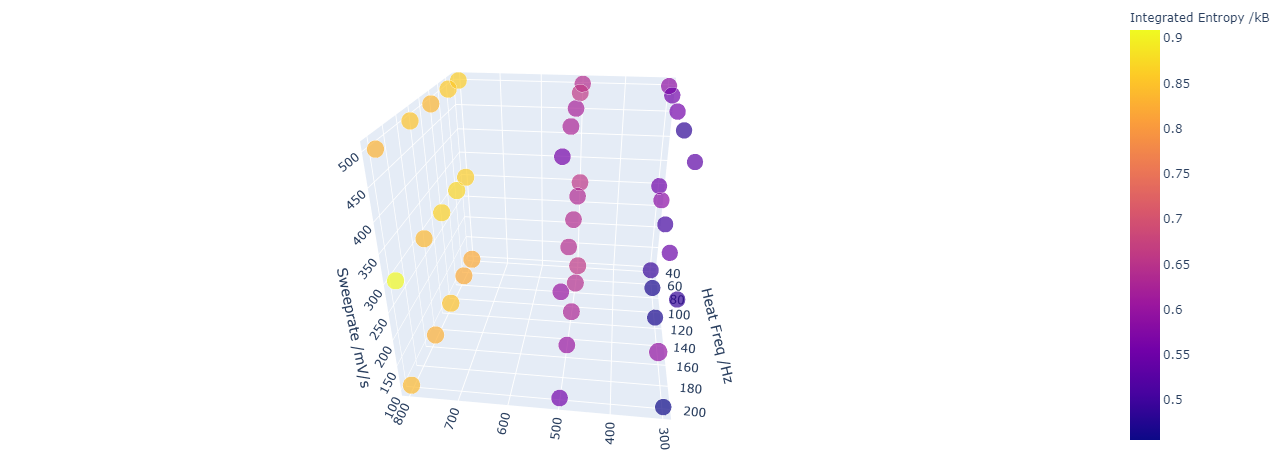

In [200]:
save_graphs = save_graphs
all_hqpcs, all_freqs, all_srs = list(), list(), list()
for pair in dat_pairs:
    dat = pair[0]
    all_hqpcs.append(dat.AWG.AWs[0][0][1])
    all_freqs.append(dat.Logs.Fastdac.measure_freq/dat.AWG.info.wave_len)
    all_srs.append(dat.Logs.sweeprate)

sizes = [fe if 0.3 < fe < 1 else 0.7 for fe in fit_entropies]
fig = px.scatter_3d(x=all_hqpcs, y=all_freqs, z=all_srs, color=integrated_entropies, size=sizes, size_max=30, labels=dict(x='HQPC /mV', y='Heat Freq /Hz', z='Sweeprate /mV/s', color='Integrated Entropy /kB'))
# sizes = [fe for fe in integrated_entropies]
# fig = px.scatter_3d(x=all_hqpcs, y=all_freqs, z=all_srs, color=fit_entropies, size=sizes, size_max=30, labels=dict(x='HQPC /mV', y='Heat Freq /Hz', z='Sweeprate /mV/s', color='Fit Entropy /kB'))
# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0), yaxis = dict(dtick = 50), scene=dict(aspectmode='cube'))
if save_graphs is True:
    fig.write_html(export_path+f'Dats{dat_pairs[0][0].datnum}-{dat_pairs[-1][0].datnum} -- Integrated Entropy Array.html')

fig

In [268]:
print(f'Frequency\tPercent of data thrown out')
for f in f_dict.values():
    print(f'{f}\t\t{15/(12195/f/4)*100:.2f}%')

Frequency	Percent of data thrown out
45		22.14%
72		35.42%
114		56.09%
150		73.80%
198		97.42%
